In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures



# Load the dataset
df = pd.read_csv('Real_Estate.csv')

# Display the first few rows to understand the structure
print(df.head())

# Checking for any null or missing values in the dataset
missing_values = df.isnull().sum()
print("\nMissing values in each column:\n", missing_values)

  Transaction date  House age  Distance to the nearest MRT station  \
0       02/09/2012       13.3                            4082.0150   
1       04/09/2012       35.5                             274.0144   
2       05/09/2012        1.1                            1978.6710   
3       05/09/2012       22.2                            1055.0670   
4       06/09/2012        8.5                             967.4000   

   Number of convenience stores   Latitude   Longitude  \
0                             8  25.007059  121.561694   
1                             2  25.012148  121.546990   
2                            10  25.003850  121.528336   
3                             5  24.962887  121.482178   
4                             6  25.011037  121.479946   

   House price of unit area  
0                  6.488673  
1                 24.970725  
2                 26.694267  
3                 38.091638  
4                 21.654710  

Missing values in each column:
 Transaction date 

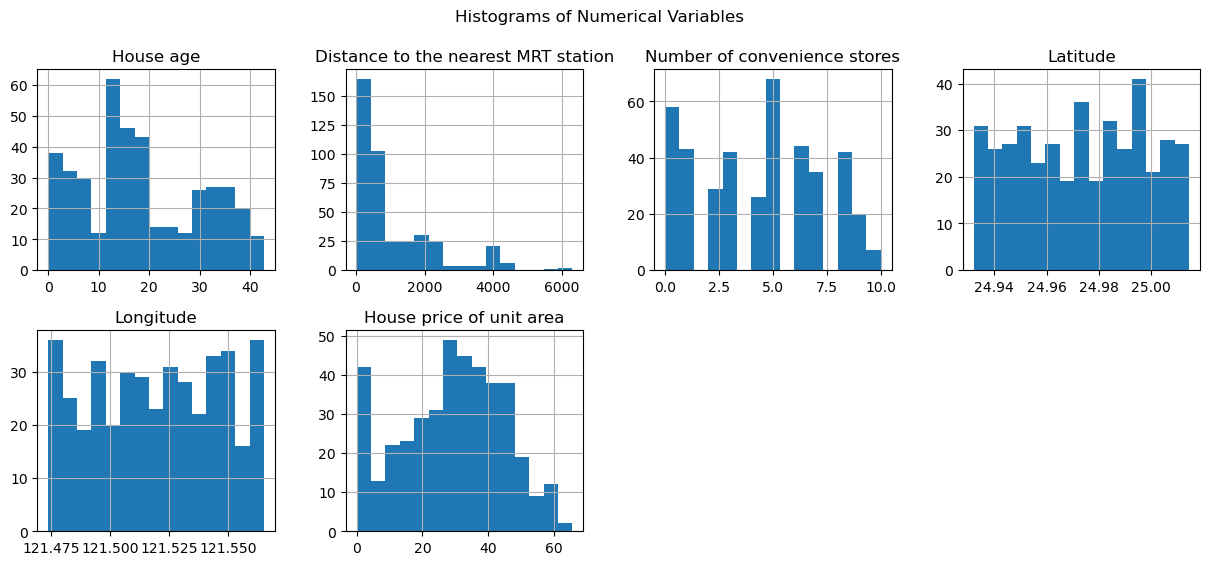

In [4]:
# Histograms for all numerical variables to check their distribution
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df[numerical_features].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.suptitle('Histograms of Numerical Variables')
plt.show()

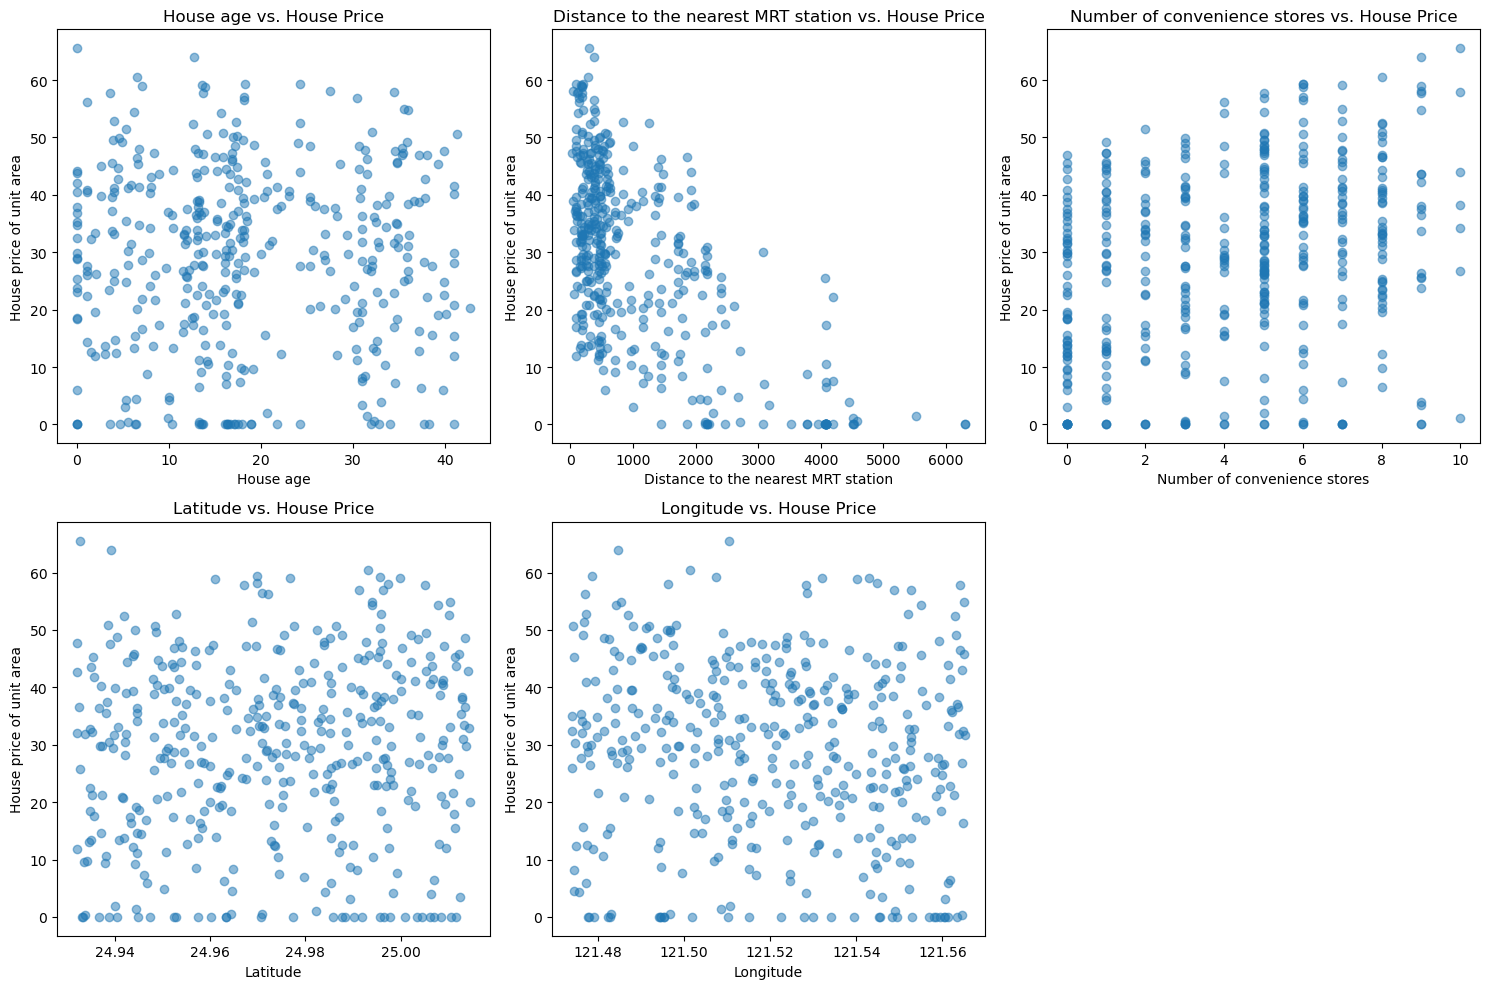

In [28]:
numerical_features = ['House age', 'Distance to the nearest MRT station', 'Number of convenience stores', 'Latitude', 'Longitude']

# Filter out the target variable if it's in your list
features_for_plot = [feature for feature in numerical_features if feature != 'House price of unit area']

# Determine the layout of the subplot grid
num_features = len(features_for_plot)
num_columns = 3  # You can adjust this based on your preference
num_rows = -(-num_features // num_columns)  # Ceiling division to get enough rows for all features

plt.figure(figsize=(5 * num_columns, 5 * num_rows))  # Adjust the figure size as needed

for i, feature in enumerate(features_for_plot, start=1):
    plt.subplot(num_rows, num_columns, i)
    plt.scatter(df[feature], df['House price of unit area'], alpha=0.5)
    plt.title(f'{feature} vs. House Price')
    plt.xlabel(feature)
    plt.ylabel('House price of unit area')

plt.tight_layout()
plt.show()

C:\Users\IBoudellioua\AppData\Local\Temp\ipykernel_23056\3676208847.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


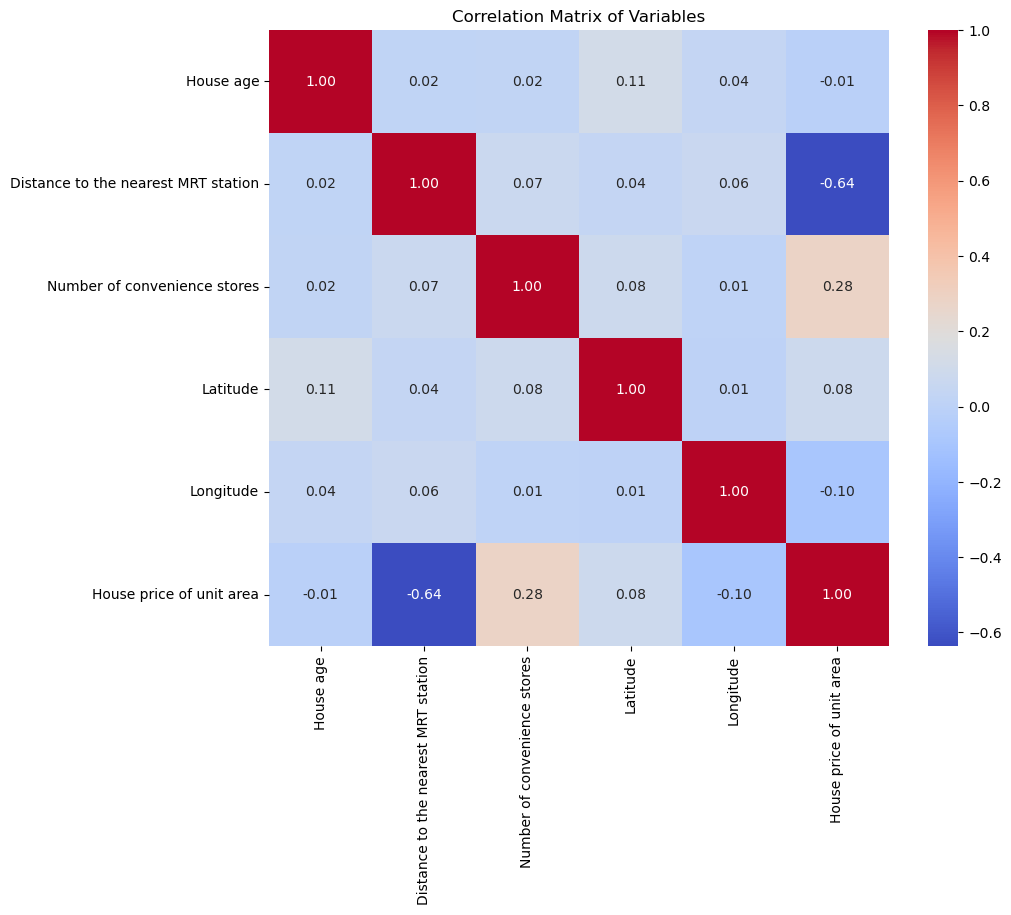

In [7]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()

In [11]:
print(corr_matrix)

                                     House age  \
House age                             1.000000   
Distance to the nearest MRT station   0.021596   
Number of convenience stores          0.021973   
Latitude                              0.114345   
Longitude                             0.036449   
House price of unit area             -0.012284   

                                     Distance to the nearest MRT station  \
House age                                                       0.021596   
Distance to the nearest MRT station                             1.000000   
Number of convenience stores                                    0.069015   
Latitude                                                        0.038954   
Longitude                                                       0.064229   
House price of unit area                                       -0.636579   

                                     Number of convenience stores  Latitude  \
House age                            

In [18]:
# Calculate the correlation matrix and select features with strong correlation with target
correlation_threshold = 0.5
corr_matrix = df.corr()
corr_with_target = corr_matrix['House price of unit area'].abs()
selected_features = corr_with_target[corr_with_target > correlation_threshold].drop('House price of unit area').index.tolist()

# Make sure selected_features is not empty and contains the correct columns
if not selected_features:
    raise ValueError("No features selected based on the correlation threshold.")

# Prepare DataFrame for VIF computation
vif_df = df[selected_features]

# Adding a constant to calculate VIF
vif_df = add_constant(vif_df)

# Ensure that there are no missing values in vif_df
if vif_df.isnull().any().any():
    raise ValueError("DataFrame contains missing values.")

# Check for multicollinearity using VIF
vif_data = pd.DataFrame({
    'VIF': [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])],
    'feature': vif_df.columns
})

print(vif_data)

# Filter out features based on VIF (common threshold values are 5 or 10)
vif_threshold = 5
features_to_use = vif_data.loc[vif_data['VIF'] < vif_threshold, 'feature'].tolist()
features_to_use.remove('const')  # Remove the constant added for VIF computation

# Final features to be used for modeling
final_features = df[features_to_use]

        VIF                              feature
0  1.793066                                const
1  1.000000  Distance to the nearest MRT station


C:\Users\IBoudellioua\AppData\Local\Temp\ipykernel_23056\3729434137.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


In [20]:
# Define your features and target variable
X = df[['Distance to the nearest MRT station']]
y = df['House price of unit area']

# Split the data into training and testing sets
# We'll keep 80% of the data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now for model selection, let's start with a simple linear regression and a more complex random forest regressor

# Initialize the models
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
linear_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
# Train the Random Forest Regressor
random_forest_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = random_forest_model.predict(X_test)

# Calculate evaluation metrics for the Random Forest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE): {mse_rf}")
print(f"Random Forest R-squared (R2): {r2_rf}")

# If you want to compare, train and evaluate Linear Regression as well
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression Mean Squared Error (MSE): {mse_linear}")
print(f"Linear Regression R-squared (R2): {r2_linear}")

Random Forest Mean Squared Error (MSE): 192.72809631215708
Random Forest R-squared (R2): 0.30333056230442657
Linear Regression Mean Squared Error (MSE): 148.27235339625543
Linear Regression R-squared (R2): 0.46402823956159855


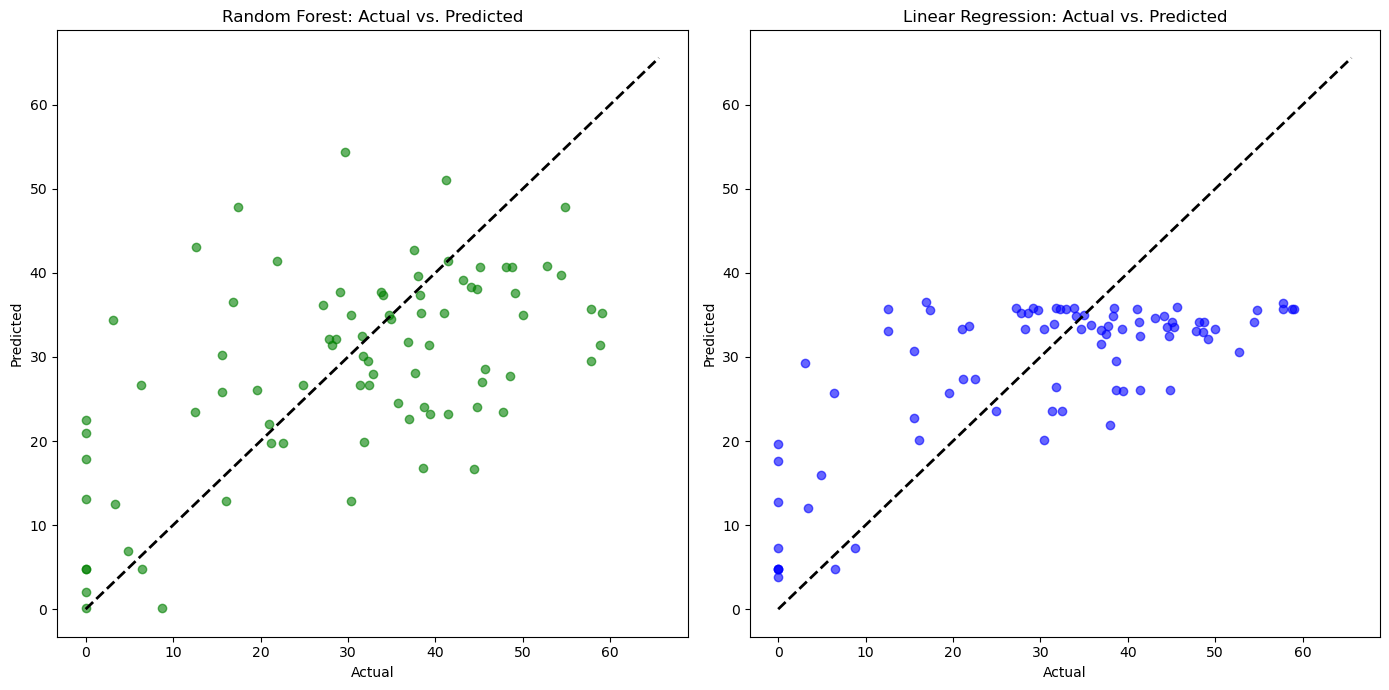

In [23]:
import matplotlib.pyplot as plt

# Predictions for both models
y_pred_rf = random_forest_model.predict(X_test)
y_pred_linear = linear_model.predict(X_test)

# Plotting the Actual vs. Predicted values
plt.figure(figsize=(14, 7))

# Random Forest predictions
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # A diagonal line where actual = predicted
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs. Predicted')

# Linear Regression predictions
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(y_test, y_pred_linear, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # A diagonal line where actual = predicted
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Actual vs. Predicted')

plt.tight_layout()
plt.show()


In [24]:
#Interpreting Linear Regression coefficients
coefficients = linear_model.coef_
intercept = linear_model.intercept_

# If you have just one feature, it can be accessed directly
print(f"Coefficient for Distance to the nearest MRT station: {coefficients[0]}")
print(f"Intercept: {intercept}")


Coefficient for Distance to the nearest MRT station: -0.00794844205226485
Intercept: 37.21129033817634


In [26]:
# Let's create polynomial features up to the 2nd degree

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_transformer.fit_transform(X)

# The new feature names can be obtained to understand the created features
feature_names = poly_transformer.get_feature_names(input_features=X.columns)

# Create a DataFrame with the new polynomial features
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

print(X_poly_df.head())

   Distance to the nearest MRT station  Distance to the nearest MRT station^2
0                            4082.0150                           1.666285e+07
1                             274.0144                           7.508389e+04
2                            1978.6710                           3.915139e+06
3                            1055.0670                           1.113166e+06
4                             967.4000                           9.358628e+05


C:\Users\IBoudellioua\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [27]:
# Split the data with the new polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Train a new Random Forest model on the polynomial features
random_forest_model.fit(X_train_poly, y_train)

# Make predictions and evaluate the model
y_pred_poly = random_forest_model.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Random Forest with Polynomial Features MSE: {mse_poly}")
print(f"Random Forest with Polynomial Features R2: {r2_poly}")


Random Forest with Polynomial Features MSE: 192.73290153820466
Random Forest with Polynomial Features R2: 0.3033131924751561
